In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import scripts.utils as utils
plot_kwargs = {'bbox_inches': "tight", 'dpi': 200}

config = utils.load_config("scripts")
tempdir = config['paths']['tempdir']
resdir = config['paths']['resultsdir']
outdir = config['paths']['resultsdir']
figdir = config['paths']['figdir']

SCENARIO = 'nf'
VARIABLE = 'ep'


def create_ts(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=16))
    df = df.drop(columns=['Year', 'Month'])
    ts = df.set_index('Date', drop=True)
    return ts


def subset_column(df, column, value):
    df = df[df[column] == value]
    df = df.drop(columns=[column])
    return df

In [2]:
# indicator data
df_ind = pd.read_parquet(os.path.join(tempdir, SCENARIO, 'indicator_series.parquet'))
df_spi = pd.read_parquet(os.path.join(tempdir, SCENARIO, 'standardised_series.parquet'))

df_ind = subset_column(df_ind, 'Variable', VARIABLE)
df_ind = subset_column(df_ind, 'scenario', SCENARIO.upper())
df_ind = subset_column(df_ind, 'buffer', 500)

df_spi = subset_column(df_spi, 'Variable', VARIABLE)
df_spi = subset_column(df_spi, 'scenario', SCENARIO.upper())
df_spi = subset_column(df_spi, 'buffer', 500)

df_ind = df_ind.rename(columns={'Value': f'{VARIABLE}_total'})
df_spi = df_spi.rename(columns={'Value': f'{VARIABLE}_total'})

ts_ind = create_ts(df_ind)
ts_spi = create_ts(df_spi)

# severity data
los_df = pd.read_csv(os.path.join(tempdir, SCENARIO, "monthly_los_melted.csv"), index_col=[0])
ts_los = create_ts(los_df)
ts_los['LoS'] = ts_los['LoS'].astype(int)

# merge it all
ts = ts_ind.copy()
ts = pd.merge(ts, ts_spi, on=['Date', 'RZ_ID', 'ensemble'])
ts = pd.merge(ts, ts_los, on=['Date', 'RZ_ID', 'ensemble'])

ts = ts[['RZ_ID', 'ensemble', 'LoS', 'ep_total', 'anomaly_mean', 'deficit_mean',
         'anomaly_q50', 'deficit_q50', 'deficit_q75', 'deficit_q90',
         'si6', 'si12', 'si24']]

ts.to_csv(os.path.join(resdir, SCENARIO, 'full_timeseries', 'ts.csv'))

In [3]:
# NEW 20/10/2023: add the number of days for each level
def add_los_level(ts, level:int):
    level_df = pd.read_csv(os.path.join(tempdir, SCENARIO, f"monthly_los_level{level}_melted.csv"), index_col=[0])
    level_df['ensemble'] = level_df['Ensemble'].apply(lambda x: "{}{}".format(SCENARIO.upper(), x))
    level_df = level_df.drop(columns='Ensemble')
    ts_level = create_ts(level_df)
    ts_level["LoS"] = ts_level["LoS"].astype(int)

    ts = pd.merge(ts, ts_level, on=['Date', 'RZ_ID', 'ensemble'], suffixes=('', f'_l{level}'))
    
    return ts

ts = add_los_level(ts, 0)
ts = add_los_level(ts, 1)
ts = add_los_level(ts, 2)
ts = add_los_level(ts, 3)
ts = add_los_level(ts, 4)


ts.to_csv(os.path.join(resdir, SCENARIO, 'full_timeseries', 'ts_with_levels.csv'))
ts.head()

# Some EDA and viz

In [6]:
ENSEMBLE = f'{SCENARIO.upper()}2'
RZ_ID = 1

ts_sub = subset_column(ts, 'ensemble', ENSEMBLE)
ts_sub = subset_column(ts_sub, 'RZ_ID', RZ_ID)

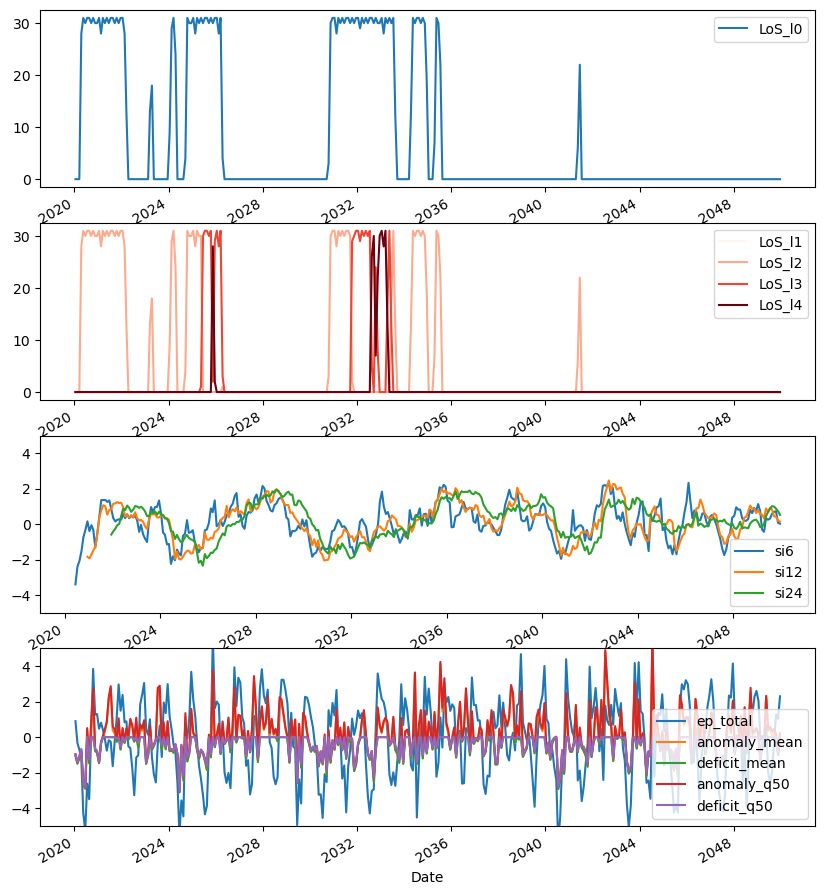

In [27]:
cmap = plt.get_cmap("Reds")

fig, axs = plt.subplots(4, 1, figsize=(10, 12))

ts_sub[['LoS_l0']].plot(ax=axs[0])
ts_sub[['LoS_l1']].plot(ax=axs[1], color=cmap(0))
ts_sub[['LoS_l2']].plot(ax=axs[1], color=cmap(0.3))
ts_sub[['LoS_l3']].plot(ax=axs[1], color=cmap(0.6))
ts_sub[['LoS_l4']].plot(ax=axs[1], color=cmap(.99))


ts_sub[['si6', 'si12', 'si24']].plot(ax=axs[2])
ts_sub[['ep_total', 'anomaly_mean', 'deficit_mean', 'anomaly_q50',
       'deficit_q50']].plot(ax=axs[3])

for ax in axs[2:]:
    ax.set_ylim([-5, 5])

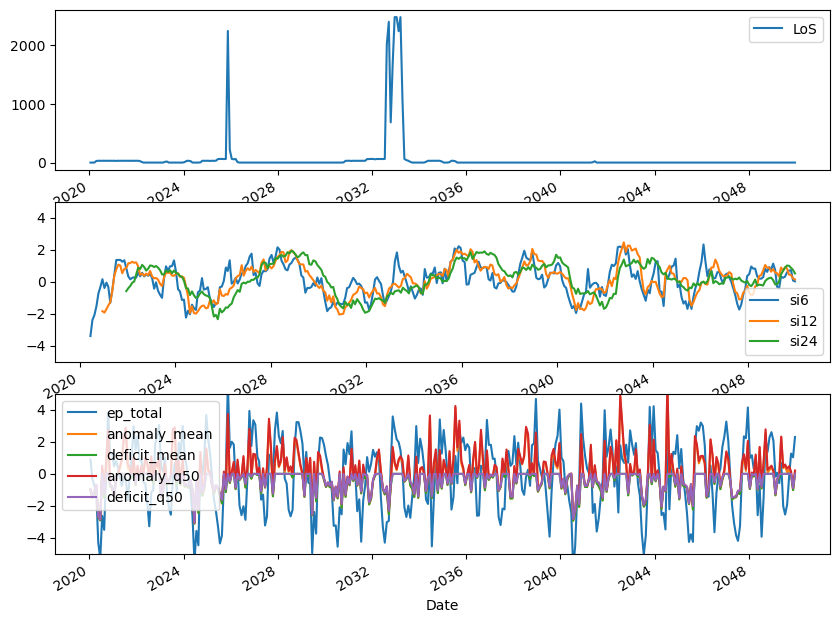

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

ts_sub[['LoS']].plot(ax=axs[0])
ts_sub[['si6', 'si12', 'si24']].plot(ax=axs[1])
ts_sub[['ep_total', 'anomaly_mean', 'deficit_mean', 'anomaly_q50',
       'deficit_q50']].plot(ax=axs[2])

for ax in axs[1:]:
    ax.set_ylim([-5, 5])

/Users/alison/mambaforge/envs/general/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


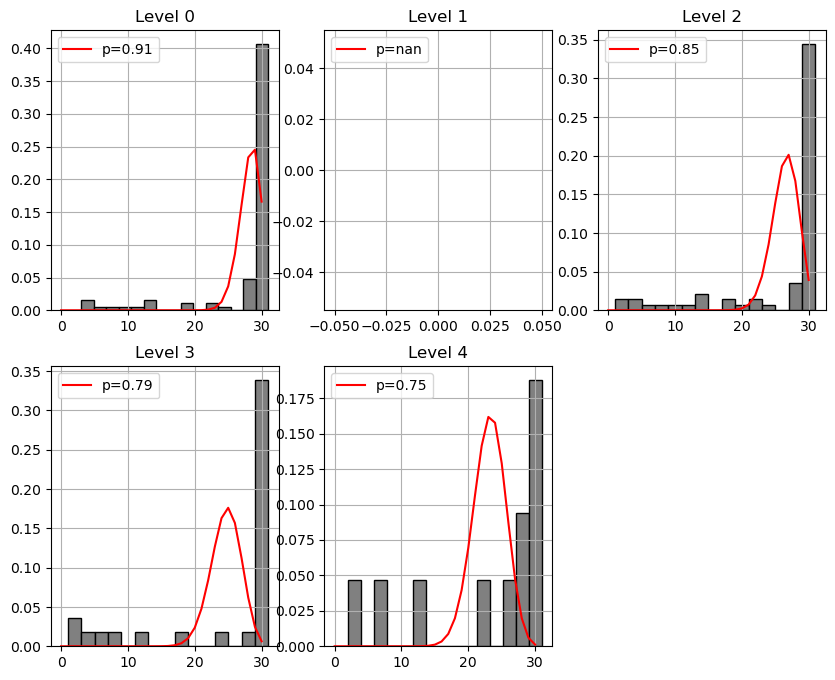

In [118]:
# LoS distributions 
from scipy.special import comb

def dbinomial(x, n=30, p=.5):
    pmf = comb(n, x) * p**x * (1 - p)**(n - x)
    return pmf

fig, axs = plt.subplots(2, 3, figsize=(10, 8))
for i, ax in zip(range(5), axs.ravel()[:-1]):
    samples = ts_sub.query(f"LoS_l{i} > 0")[f"LoS_l{i}"].reset_index()
    samples[f'LoS_l{i}'].hist(ax=ax, bins=15, color='grey', edgecolor='k', density=True)
    ax.set_title(f"Level {i}")
    
    # fit Binomial MLE
    samples['n'] = samples['Date'].dt.daysinmonth
    samples['MLE'] = samples[f"LoS_l{i}"] / samples['n']
    p_hat = samples["MLE"].mean()
    
    # plot fitted MLE
    x = np.arange(0, 31, 1, dtype=int)
    y = dbinomial(x, n=31, p=p_hat)

    ax.plot(x, y, color='red', label=f'p={p_hat:.2f}')
    ax.legend(loc='upper left')
    
fig.delaxes(axs[-1,-1])